In [ ]:
#!jt -t onedork -fs 95 -tfs 11 -nfs 115 -cellw 88% -T

In [1]:
# coding: utf-8
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from os import listdir, makedirs
from os.path import join, isfile, isdir, exists
import pandas as pd
import gc
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import CoherenceModel, TfidfModel, LdaModel, LdaMulticore
from gensim.models.hdpmodel import HdpModel, HdpTopicFormatter
from gensim.models.callbacks import CoherenceMetric, DiffMetric, PerplexityMetric, ConvergenceMetric
from gensim.utils import revdict
from gensim.models.coherencemodel import COHERENCE_MEASURES
from gensim import utils
from itertools import chain, islice
from constants import (
    FULL_PATH, ETL_PATH, NLP_PATH, SMPL_PATH, POS, NOUN, PROPN, TOKEN, HASH, SENT_IDX, PUNCT
)
import logging
import json
import numpy as np

#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
pd.options.display.max_rows = 2001
np.set_printoptions(precision=3, threshold=None, edgeitems=None, linewidth=800, suppress=None)

def report_on_oov_terms(cm, topic_models):
    """OOV = out-of-vocabulary"""
    topics_as_topn_terms = [
        models.CoherenceModel.top_topics_as_word_lists(model, dictionary)
        for model in topic_models
    ]

    oov_words = cm._accumulator.not_in_vocab(topics_as_topn_terms)
    print('number of oov words: %d' % len(oov_words))
    
    for num_topics, words in zip(trained_models.keys(), topics_as_topn_terms):
        oov_words = cm._accumulator.not_in_vocab(words)
        print('number of oov words for num_topics=%d: %d' % (num_topics, len(oov_words)))

#report_on_oov_terms(cm, trained_models.values())

datasets = {
    'E': 'Europarl',
    'FA': 'FAZ_combined',
    'FO': 'FOCUS_cleansed',
    'O': 'OnlineParticipation',
    'P': 'PoliticalSpeeches',
    'dewi': 'dewiki',
    'dewa': 'dewac',
}
bad_tokens = {
    'Europarl': [
        'E.', 'Kerr', 'The', 'la', 'ia', 'For', 'Ieke', 'the',
    ],
    'FAZ_combined': [
        'S.', 'j.reinecke@faz.de', 'B.',
    ],
    'FOCUS_cleansed': [],
    'OnlineParticipation': [
        'Re', '@#1', '@#2', '@#3', '@#4', '@#5', '@#6', '@#7', '@#8', '@#9', '@#1.1', 'Für', 'Muss',
        'etc', 'sorry', 'Ggf', 'u.a.', 'z.B.', 'B.', 'stimmt', ';-)', 'lieber', 'o.', 'Ja', 'Desweiteren',
    ],
    'PoliticalSpeeches': [],
    'dewiki': [],
    'dewac': [],
}
all_bad_tokens = set(chain(*bad_tokens.values()))
params_list = ['a42', 'b42', 'c42', 'd42', 'e42']
placeholder = '[[PLACEHOLDER]]'

dataset = datasets['O']
file = f'{dataset}_LDAmodel_a42_10'

# load model
ldamodel = LdaModel.load(join(ETL_PATH, 'LDAmodel', 'a42', file))
dict_from_model = ldamodel.id2word

split_type = 'fullset'
corpus_type = 'bow'
file_name = f'{dataset}_{split_type}_nouns_{corpus_type}'

# load dictionary
# !!! Attention: this is a different dictionary from model dict with a different word<->id mapping
dict_path = join(ETL_PATH, 'LDAmodel', file_name + '.dict')
dict_from_corpus = Dictionary.load(dict_path)
dict_from_corpus.add_documents([[placeholder]])
dict_from_corpus[0]

# load corpus (for u_mass scores)
corpus_path = join(ETL_PATH, 'LDAmodel', file_name + '.mm')
corpus = MmCorpus(corpus_path)
print(corpus)
corpus = list(corpus)
# this!
corpus.append([(dict_from_corpus.token2id[placeholder], 1.0)])

# load texts (for s_v scores)
doc_path = join(ETL_PATH, 'LDAmodel', file_name.rstrip(f'{corpus_type}') + 'texts.json')
with open(doc_path, 'r') as fp:
    texts = json.load(fp)
# this!
texts.append([placeholder])

# buil topic representation matrix
nbtopics = int(file.split('_')[-1])
topn = 20
topics = [
    [dataset] +
    [dict_from_model[term[0]] for term in ldamodel.get_topic_terms(i, topn=topn)]
    for i in range(nbtopics)
]
df_topics = pd.DataFrame(topics, columns=['dataset'] + ['term' + str(i) for i in range(topn)])
df_topics = df_topics.applymap(lambda x: placeholder if x in all_bad_tokens else x)
topic_terms = df_topics.iloc[:, 1:]
topic_terms_ids = topic_terms.applymap(lambda x: dict_from_corpus.token2id[x])

-----

We will now determine which of the top 20 topic termins are most distracting for the topic coherence and omit them as topic references.

In [167]:
%%time

ref_topics_ids = topic_terms_ids.iloc[:, :10]
ref_topics_terms = topic_terms.iloc[:, :10]

# from the top20 terms construct all topic set that omit one term, resulting in 20 topics with 19 topic terms for each topic
shifted_frames = []
for i in range(topn):
    df = pd.DataFrame(np.roll(topic_terms_ids.values, shift=-i, axis=1))
    shifted_frames.append(df)
shifted_terms = pd.concat(shifted_frames)
# omit the first topic term, then the second and append the first etc...
top19_topics = shifted_terms.iloc[:, 1:].values.tolist()
print('topics shape: %s' % str(np.asarray(top19_topics).shape))


def reranked_topic_ids(data, measure, coherence_model=None):
    
    print(f'produce scores for {measure}')
    # calculate the scores for all shifted topics
    kwargs = dict(topics=top19_topics, dictionary=dict_from_corpus, coherence=measure, topn=topn-1)
    if measure == 'u_mass':
        kwargs['corpus'] = data
    else:
        kwargs['texts'] = data
    
    if coherence_model is None:
        cm = CoherenceModel(**kwargs)
    else:
        cm = coherence_model
        cm.coherence = measure
    
    scores = cm.get_coherence_per_topic()
    #print('\nlist of scores (first 25):')
    #print(np.asarray(scores[:25]))

    scores2d = np.reshape(scores, (topn, -1)).T
    #print('\nscores reshaped by rows=topics, columns=scores per topic terms:')
    #print(scores2d)

    # sanity check that everything is working as expected
    print('\nsanity checks for \'worst tokens\':')
    print(np.max(scores2d, axis=1))
    worst_scores = np.argmax(scores2d, axis=1)
    print(worst_scores)
    for i in range(len(topic_terms)):
        print(topic_terms.iat[i, worst_scores[i]])

    # the highest values indicate the terms whose absence improves the topic coherence most
    sorted_scores = np.argsort(scores2d, axis=1)
    #print('\nterm topic-indices sorted by scores:')
    #print(sorted_scores)

    # thus we will keep the first 10 indices
    top_scores = sorted_scores[:, :10]
    # and sort them back for convenience
    top_scores = np.sort(top_scores, axis=1)
    #print('\nterm topic-indices filtered (top10) and resorted:')
    #print(top_scores)

    # out of place score compared to the reference topics
    refgrid = np.mgrid[0:10,0:10][1]
    print('\nout of place scores compared to original topic terms:')
    print(np.abs(top_scores - refgrid).sum())

    # replacing indices with token-ids
    tpx_ids = []
    for i in range(10):
        tpx = topic_terms_ids.values[i, top_scores[i]]
        tpx_ids.append(tpx)
    tpx_ids = pd.DataFrame.from_records(tpx_ids, columns=ref_topics_ids.columns[:10])
    
    return tpx_ids, cm

umass_topics_ids, _ = reranked_topic_ids(corpus, 'u_mass')
cv_topics_ids, _ = reranked_topic_ids(texts, 'c_v')
cuci_topics_ids, cm = reranked_topic_ids(texts, 'c_uci')
cnpmi_topics_ids, _ = reranked_topic_ids(texts, 'c_npmi', cm)

# replacing token-ids with tokens -> resulting in the final top10 topics candidates
umass_topics_terms = umass_topics_ids.applymap(lambda x: dict_from_corpus[x])
cv_topics_terms = cv_topics_ids.applymap(lambda x: dict_from_corpus[x])
cuci_topics_terms = cuci_topics_ids.applymap(lambda x: dict_from_corpus[x])
cnpmi_topics_terms = cnpmi_topics_ids.applymap(lambda x: dict_from_corpus[x])

topics shape: (200, 19)
produce scores for u_mass

sanity checks for 'worst tokens':
[-3.506 -5.876 -2.599 -4.074 -3.047 -3.24  -2.516 -3.602 -3.509 -2.11 ]
[ 8 18 14  9 15 11  9 13  8  9]
[[PLACEHOLDER]]
Engelshof
Grünfläche
[[PLACEHOLDER]]
Mädchen
Festival
Problem
Fahrradständer
Verkehrssicherheit
Fahrradweg

out of place scores compared to original topic terms:
419
produce scores for c_v

sanity checks for 'worst tokens':
[0.529 0.42  0.578 0.554 0.782 0.553 0.584 0.421 0.476 0.773]
[17 16 11 10 17 11 11 13 10 14]
Hund
Höhe
Vorschlag
Hochschule
Dame
Festival
Stadt
Fahrradständer
Gehweg
Stelle

out of place scores compared to original topic terms:
257
produce scores for c_uci

sanity checks for 'worst tokens':
[-0.793 -2.22  -0.073 -1.436 -0.185 -0.685  0.424 -0.654 -0.998  0.897]
[ 8 18 18 10 15 11 11 12 17  6]
[[PLACEHOLDER]]
Engelshof
Vielfalt
Hochschule
Mädchen
Festival
Stadt
EUR
Haushalt
Weg

out of place scores compared to original topic terms:
244
produce scores for c_npmi

sa

-----

comparing results with reference coherence scores of original topics

In [168]:
# combining the topics candidates
ref_topics_terms.loc[:, 'source'] = 'ref'
umass_topics_terms.loc[:, 'source'] = 'umass'
cv_topics_terms.loc[:, 'source'] = 'cv'
cuci_topics_terms.loc[:, 'source'] = 'cuci'
cnpmi_topics_terms.loc[:, 'source'] = 'cnpmi'

topics_candidates = pd.concat([ref_topics_terms, umass_topics_terms, cv_topics_terms, cuci_topics_terms, cnpmi_topics_terms], axis=0)

def count_terms(x):
    # count terms and remove placeholder
    y = x.apply(pd.value_counts).sum(axis=1).astype(np.int16).sort_values(ascending=False)
    y = y[y.index != placeholder]

    # restore original order
    reference_order = pd.Index(x[x.index.get_level_values('source') == 'ref'].squeeze())
    # this is a bit delicate for terms with the same (min) count which may or may not be in the final set
    min_vote = y[9]
    min_vote2 = y[10]
    split_on_min_vote = (min_vote == min_vote2)
    
    def indices(x):
        if x in reference_order:
            idx = reference_order.get_loc(x)
        else:
            idx = 10
        return idx

    df = y.to_frame(name='counter')
    df['idx'] = y.index.map(indices)

    if split_on_min_vote:
        nb_above = (y > min_vote).sum()
        remaining_places = 10 - nb_above
        df_min = df[df.counter == min_vote]
        df_min = df_min.sort_values('idx')
        df_min = df_min[:remaining_places]
        df_above = df[df.counter > min_vote]
        df = df_above.append(df_min)
    else:
        df = df[df.counter >= min_vote]

    df = df.sort_values('idx')
    return pd.Series(df.index)

tc_grouped = (
    topics_candidates
    .sort_index(kind='mergesort')
    .assign(topic=lambda x: x.index)
    .set_index(['topic', 'source'])
)
topic_votes = tc_grouped.groupby('topic').apply(count_terms)
topic_votes = topic_votes.rename(columns=lambda x: topics_candidates.columns[x])
topic_votes['source'] = 'vote'
topics_candidates = topics_candidates.append(topic_votes)

/home/andreas/bin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/andreas/bin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [169]:
topics_candidates

,term0,term1,term2,term3,term4,term5,term6,term7,term8,term9,source
0,Stadt,Bürger,Jahr,Mensch,Projekt,Platz,Köln,Idee,[[PLACEHOLDER]],Möglichkeit,ref
1,Kind,Straßenbeleuchtung,Laterne,Beleuchtung,Straßenlaterne,Spielplatz,Vorschlag,Straße,Woche,Tag,ref
2,Kind,Schule,Stadt,Jahr,Gebäude,Geld,Bad_Godesberg,Platz,Jugendliche,Mensch,ref
3,Vorschlag,Moderation,Verwaltung,Gruß,Stadtverwaltung,Kommentar,Dank,Hinweis,Dialog,[[PLACEHOLDER]],ref
4,Beitrag,Vorschlag,Dank,Kategorie,Verständnis,Thema,Auswertung,Moderation,Themenbereich,Radverkehrsführung,ref
5,Bonn,Euro,Mitarbeiter,Oper,Stadt,Vorschlag,Jahr,Kosten,Toilette,Geld,ref
6,Radweg,Radfahrer,Fußgänger,Straße,Fahrradstraße,Rad,Seite,Richtung,Auto,Problem,ref
7,Auto,Parkplatz,Stelle,Monat,Park,Leute,Weg,Fahrrad,Rad,Jahr,ref
8,Stadt,Köln,Kosten,Einnahme,KVB,Stadt_Köln,Bus,Fahrzeug,Verkehrssicherheit,Vorschlag,ref
9,Radfahrer,Straße,Richtung,Autofahrer,Auto,Radweg,Weg,Ampel,Fußgänger,Fahrradweg,ref


In [170]:
tc_grouped = (
    topics_candidates
    .sort_index(kind='mergesort')
    .assign(topic=lambda x: x.index)
    .set_index(['topic', 'source'])
)
tc_grouped

term0               term1           term2  \
topic source                                                           
0     ref                  Stadt              Bürger            Jahr   
      umass                Stadt              Bürger            Jahr   
      cv                   Stadt              Bürger            Jahr   
      cuci                 Stadt              Bürger            Jahr   
      cnpmi                Stadt              Bürger            Jahr   
      vote                 Stadt              Bürger            Jahr   
1     ref                   Kind  Straßenbeleuchtung         Laterne   
      umass                 Kind  Straßenbeleuchtung         Laterne   
      cv      Straßenbeleuchtung         Beleuchtung      Spielplatz   
      cuci                  Kind             Laterne     Beleuchtung   
      cnpmi                 Kind  Straßenbeleuchtung         Laterne   
      vote                  Kind  Straßenbeleuchtung         Laterne   
2     ref                   Kind              Schule           Stadt   
      umass                 Kind              Schule           Stadt   
      cv                    Kind              Schule           Stadt   
      cuci                  Kind              Schule           Stadt   
      cnpmi                 Kind              Schule           Stadt   
      vote                  Kind              Schule           Stadt   
3     ref              Vorschlag          Moderation      Verwaltung   
      umass            Vorschlag       Unterstützung  Bürgerhaushalt   
      cv              Moderation          Verwaltung            Gruß   
      cuci             Vorschlag          Moderation      Verwaltung   
      cnpmi            Vorschlag          Moderation      Verwaltung   
      vote             Vorschlag          Moderation      Verwaltung   
4     ref                Beitrag           Vorschlag            Dank   
      umass              Beitrag           Vorschlag            Dank   
      cv                 Beitrag                Dank       Kategorie   
      cuci               Beitrag           Vorschlag            Dank   
      cnpmi              Beitrag           Vorschlag            Dank   
      vote               Beitrag           Vorschlag            Dank   
5     ref                   Bonn                Euro     Mitarbeiter   
      umass                 Bonn                Euro     Mitarbeiter   
      cv                    Bonn                Euro            Oper   
      cuci                  Bonn                Oper           Stadt   
      cnpmi                 Bonn                Euro            Oper   
      vote                  Bonn                Euro            Oper   
6     ref                 Radweg           Radfahrer       Fußgänger   
      umass               Radweg           Radfahrer       Fußgänger   
      cv                  Radweg           Radfahrer       Fußgänger   
      cuci                Radweg           Radfahrer       Fußgänger   
      cnpmi               Radweg           Radfahrer       Fußgänger   
      vote                Radweg           Radfahrer       Fußgänger   
7     ref                   Auto           Parkplatz          Stelle   
      umass                 Auto           Parkplatz          Stelle   
      cv                    Auto           Parkplatz          Stelle   
      cuci                  Auto           Parkplatz          Stelle   
      cnpmi                 Auto           Parkplatz          Stelle   
      vote                  Auto           Parkplatz          Stelle   
8     ref                  Stadt                Köln          Kosten   
      umass                Stadt                Köln          Kosten   
      cv                   Stadt                Köln          Kosten   
      cuci                 Stadt                Köln          Kosten   
      cnpmi                Stadt                Köln          Kosten   
      vote                 Stadt                Köln          Koste

### Start c_uci and c_npmi coherence measures
c_v and c_uci and c_npmi all use the boolean sliding window approach of estimating probabilities. Since the `CoherenceModel` caches the accumulated statistics, calculation of c_uci and c_npmi are practically free after calculating c_v coherence. These two methods are simpler and were shown to correlate less with human judgements than c_v but more so than u_mass.

In [177]:
# reference scores per topic for top 10 topic terms
top10_topics_ids = topics_candidates.drop('source', axis=1).values.tolist()


#CoherenceModel.for_topics(topics_as_topn_terms=topics, corpus=corpus, dictionary=dictionary, coherence='u_mass')
cm_umass = CoherenceModel(topics=top10_topics_ids, corpus=corpus, dictionary=dict_from_corpus, coherence='u_mass', topn=10)
umass_scores = cm_umass.get_coherence_per_topic(with_std=False, with_support=False)

cm_cv = CoherenceModel(topics=top10_topics_ids, texts=texts, dictionary=dict_from_corpus, coherence='c_v', topn=10)
cv_scores = cm_cv.get_coherence_per_topic()

cm_cv = CoherenceModel(topics=top10_topics_ids, texts=texts, dictionary=dict_from_corpus, coherence='c_uci', topn=10)
cuci_scores = cm_cv.get_coherence_per_topic()

cm_cv.coherence = 'c_npmi' # reusing probabilities
cnpmi_scores = cm_cv.get_coherence_per_topic()

def stats(scores):
    df = pd.DataFrame(np.reshape(scores, (6, 10)), index=['reference', 'u_mass', 'c_v', 'c_uci', 'c_npmi', 'vote']).T
    df.plot()
    descr = df.describe()
    mean = descr.loc['mean']
    bestidx = mean.idxmax()
    bestval = mean[bestidx]
    print(f'topic reranking with highest score: {bestidx} [{round(bestval, 3)}]')
    return descr

topic reranking with highest score: vote [-2.406]


,reference,u_mass,c_v,c_uci,c_npmi,vote
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,-3.374057,-2.871638,-3.465084,-2.515094,-2.413299,-2.405760
std,1.918271,0.548584,2.634068,0.487174,0.586107,0.596602
min,-6.767347,-3.691406,-9.724838,-3.122034,-3.098825,-3.269675
25%,-3.554271,-3.196917,-2.908391,-2.771288,-2.684959,-2.684959
50%,-2.790760,-2.893525,-2.599791,-2.602960,-2.542725,-2.554484
75%,-2.325584,-2.624404,-2.173201,-2.425599,-2.200603,-2.202883
max,-0.884698,-1.683506,-0.907431,-1.331290,-1.005928,-1.005928


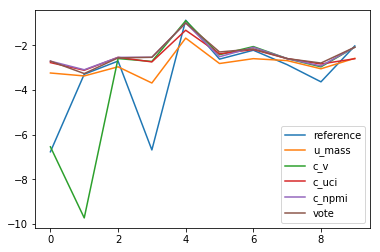

In [178]:
# changed segmentation for c_uci and c_npmi from s_one_set to s_one_one (default)
df = stats(umass_scores)
df

topic reranking with highest score: c_npmi


,reference,u_mass,c_v,c_uci,c_npmi,vote
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,-3.374057,-2.871638,-3.465084,-2.632167,-2.458152,-2.468651
std,1.918271,0.548584,2.634068,0.530953,0.655544,0.630056
min,-6.767347,-3.691406,-9.724838,-3.322205,-3.122034,-3.228231
25%,-3.554271,-3.196917,-2.908391,-2.981510,-2.877733,-2.832187
50%,-2.790760,-2.893525,-2.599791,-2.628802,-2.630080,-2.596485
75%,-2.325584,-2.624404,-2.173201,-2.489789,-2.152929,-2.150664
max,-0.884698,-1.683506,-0.907431,-1.516049,-0.907431,-1.058342


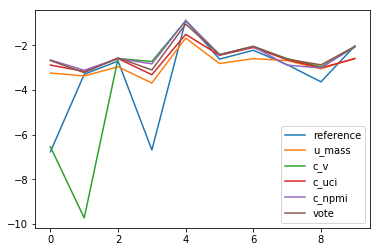

In [161]:
df = stats(umass_scores)
df

topic reranking with highest score: c_v [0.721]


,reference,u_mass,c_v,c_uci,c_npmi,vote
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.634403,0.621864,0.720626,0.675843,0.707297,0.696188
std,0.156860,0.176038,0.145637,0.141508,0.144884,0.151749
min,0.415706,0.322773,0.465073,0.463536,0.466110,0.451704
25%,0.541053,0.537958,0.624268,0.598746,0.636163,0.585116
50%,0.606302,0.628573,0.740596,0.654950,0.727201,0.725047
75%,0.682945,0.688264,0.778752,0.747135,0.769769,0.751540
max,0.975126,0.956579,0.988105,0.959240,0.980850,0.980850


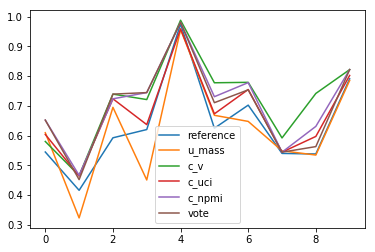

In [179]:
# changed segmentation for c_uci and c_npmi from s_one_set to s_one_one (default)
df = stats(cv_scores)
df

topic reranking with highest score: c_npmi


,reference,u_mass,c_v,c_uci,c_npmi,vote
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.633820,0.621187,0.720172,0.688504,0.727139,0.713658
std,0.157032,0.176243,0.145682,0.141313,0.141928,0.145424
min,0.415049,0.321956,0.465002,0.436122,0.462662,0.440977
25%,0.540289,0.537078,0.623474,0.616793,0.712092,0.659750
50%,0.605751,0.627827,0.740016,0.690598,0.729061,0.719489
75%,0.682259,0.687596,0.778211,0.756555,0.778211,0.778211
max,0.975075,0.956499,0.988086,0.949645,0.988086,0.977063


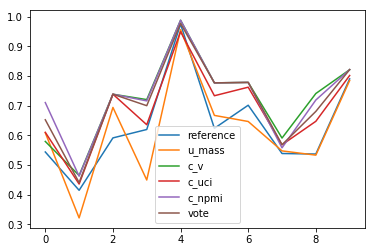

In [158]:
df = stats(cv_scores)
df

topic reranking with highest score: c_npmi [0.778]


,reference,u_mass,c_v,c_uci,c_npmi,vote
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.049386,0.046820,-0.041353,0.636854,0.778367,0.715566
std,1.196367,1.060777,1.935162,0.755247,0.784456,0.812327
min,-2.246823,-2.149973,-4.284396,-0.045676,0.030241,0.007287
25%,-0.262444,-0.294038,-0.069299,0.110471,0.254051,0.201890
50%,0.121383,-0.024076,0.396112,0.359856,0.522202,0.398556
75%,0.519458,0.438740,0.974221,0.999926,0.984142,0.959146
max,2.345263,1.975001,2.558902,2.415537,2.592244,2.592244


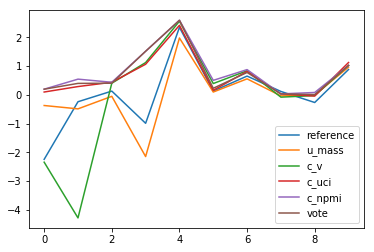

In [180]:
# changed segmentation for c_uci and c_npmi from s_one_set to s_one_one (default)
df = stats(cuci_scores)
df

topic reranking with highest score: c_npmi


,reference,u_mass,c_v,c_uci,c_npmi,vote
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.200968,0.752430,0.272746,0.931818,1.086849,1.005682
std,1.419215,0.677839,2.203047,0.559195,0.703822,0.641692
min,-2.493440,-0.112313,-4.792652,0.227986,0.291924,0.171867
25%,0.135734,0.444946,0.659300,0.606269,0.840741,0.703435
50%,0.519382,0.631696,1.002718,0.863487,0.998074,0.976503
75%,0.759544,0.821087,1.158096,0.958271,1.137893,1.060844
max,2.504861,2.420483,2.923230,2.282591,2.923230,2.618942


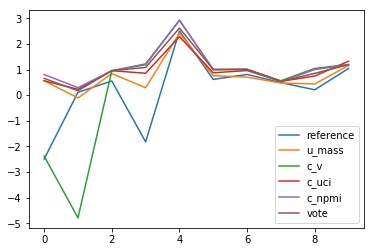

In [159]:
df = stats(cuci_scores)
df

topic reranking with highest score: c_npmi [0.14]


,reference,u_mass,c_v,c_uci,c_npmi,vote
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.095975,0.068890,0.100356,0.112367,0.139646,0.130749
std,0.159992,0.137488,0.183835,0.144843,0.163721,0.167411
min,-0.060491,-0.061332,-0.129382,0.001818,0.010677,0.009962
25%,0.023728,0.002818,0.004959,0.020445,0.039981,0.032645
50%,0.036417,0.018016,0.062303,0.053220,0.073545,0.058954
75%,0.114241,0.081367,0.175233,0.155474,0.176907,0.172006
max,0.513681,0.420774,0.532256,0.480555,0.559175,0.559175


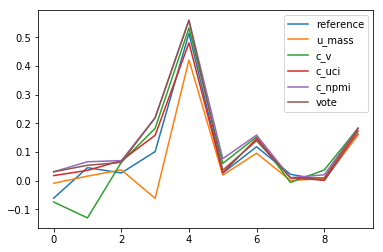

In [181]:
# changed segmentation for c_uci and c_npmi from s_one_set to s_one_one (default)
df = stats(cnpmi_scores)
df

topic reranking with highest score: c_npmi


,reference,u_mass,c_v,c_uci,c_npmi,vote
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.162278,0.161090,0.202793,0.195499,0.235999,0.221082
std,0.179486,0.138433,0.208281,0.124806,0.171033,0.157467
min,-0.004902,0.007843,-0.123896,0.050429,0.061126,0.048495
25%,0.093499,0.096163,0.137411,0.129485,0.181154,0.149737
50%,0.109652,0.133321,0.207579,0.178726,0.212746,0.201821
75%,0.164871,0.173610,0.223356,0.209051,0.223356,0.223356
max,0.637585,0.514085,0.691834,0.511489,0.691834,0.632628


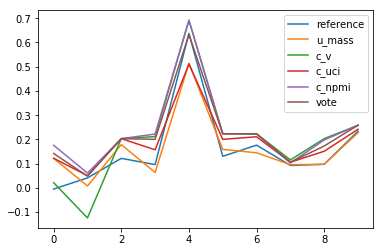

In [160]:
df = stats(cnpmi_scores)
df